In [1]:
import math
from typing import Optional, Union

import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch

import gym
from gym import logger, spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

# Environment

In [77]:
class CartPoleEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    def __init__(self, masspole=0.1):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = "euler"

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                self.theta_threshold_radians * 2,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state = None

        self.steps_beyond_terminated = None

    def step(self, force):
        #err_msg = f"{action!r} ({type(action)}) invalid"
        #assert self.action_space.contains(action), err_msg
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot = self.state
        #force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * theta_dot**2 * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not terminated:
            reward = - .2*np.abs(force)
        elif self.steps_beyond_terminated is None:
            # Pole just fell!
            self.steps_beyond_terminated = 0
            reward = - 1000
        else:
            if self.steps_beyond_terminated == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned terminated = True. You "
                    "should always call 'reset()' once you receive 'terminated = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_terminated += 1
            reward = 0.0

        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
        )  # default high
        self.state = self.np_random.uniform(low=low, high=high, size=(4,))
        self.steps_beyond_terminated = None

        return np.array(self.state, dtype=np.float32), {}

# Discretizer

In [3]:
class Discretizer:
    def __init__(
        self,
        min_points_states,
        max_points_states,
        bucket_states,
        min_points_actions,
        max_points_actions,
        bucket_actions,
        ):
        self.min_points_states = np.array(min_points_states)
        self.max_points_states = np.array(max_points_states)
        self.bucket_states = np.array(bucket_states)
        self.range_states = self.max_points_states - self.min_points_states

        self.min_points_actions = np.array(min_points_actions)
        self.max_points_actions = np.array(max_points_actions)
        self.bucket_actions = np.array(bucket_actions)
        # Think this better
        self.spacing_actions = (self.max_points_actions - self.min_points_actions) / (self.bucket_actions - 1)

        self.range_actions = self.max_points_actions - self.min_points_actions

        self.n_states = np.round(self.bucket_states).astype(int)
        self.n_actions = np.round(self.bucket_actions).astype(int)
        self.dimensions = np.concatenate((self.n_states, self.n_actions))

    def get_state_index(self, state):
        state = np.clip(state, a_min=self.min_points_states, a_max=self.max_points_states)
        scaling = (state - self.min_points_states) / self.range_states
        state_idx = np.round(scaling * (self.bucket_states - 1)).astype(int)
        return tuple(state_idx.tolist())

    def get_action_index(self, action):
        action = np.clip(action, a_min=self.min_points_actions, a_max=self.max_points_actions)
        scaling = (action - self.min_points_actions) / self.range_actions
        action_idx = np.round(scaling * (self.bucket_actions - 1)).astype(int)
        return tuple(action_idx.tolist())

    def get_action_from_index(self, action_idx):
        return self.min_points_actions + action_idx * self.spacing_actions

# Model

In [16]:
class PARAFAC(torch.nn.Module):
    def __init__(self, dims, k, scale=1.0):
        super().__init__()

        self.k = k
        self.n_factors = len(dims)

        factors = []
        for dim in dims:
            factor = scale*torch.randn(dim, k, dtype=torch.double, requires_grad=True)
            factors.append(torch.nn.Parameter(factor))
        self.factors = torch.nn.ParameterList(factors)

    def forward(self, indices):
        prod = torch.ones(self.k, dtype=torch.double)
        for i in range(len(indices)):
            idx = indices[i]
            factor = self.factors[i]
            prod *= factor[idx, :]
        if len(indices) < len(self.factors):
            return torch.matmul(prod, self.factors[-1].T)
        return torch.sum(prod, dim=-1)

# Training - Q-Learning

In [83]:
mass = 20
env = CartPoleEnv(mass)
nS = 10
nA = 20

In [84]:
discretizer = Discretizer(
    min_points_states=[-4.8, -0.5, -0.42, -0.9],
    max_points_states=[4.8, 0.5, 0.42, 0.9],
    bucket_states=[nS]*4,
    min_points_actions=[-10],
    max_points_actions=[10],
    bucket_actions=[nA],
)

In [85]:
E = 50_000
H = 100
lr = 0.1
eps = 1.0
eps_decay = 0.999995
eps_min = 0.0
gamma = 0.99

def select_action(Q, s_idx, epsilon):
    if np.random.rand() < epsilon:
        idx = np.random.choice(nA)
    else:
        idx = Q[s_idx].argmax()   
    a = discretizer.get_action_from_index(idx)
    return a[0], idx

Gs = []
Eps = []
As = []
Q = np.zeros([nS, nS, nS, nS, nA])
for episode in range(E):
    G = 0
    s, _ = env.reset()
    s_idx = discretizer.get_state_index(s)
    for h in range(H):
        a, a_idx = select_action(Q, s_idx, eps)
        sp, r, d, _, _ = env.step(a)
        sp_idx = discretizer.get_state_index(sp)
        
        G += r
        
        m = -1*(d - 1)
        q_target = r + gamma * m * Q[sp_idx].max()
        q_hat = Q[s_idx + tuple([a_idx])]
        
        Q[s_idx + tuple([a_idx])] += lr*(q_target - q_hat)
        
        if d:
            break
            
        s = sp
        s_idx = sp_idx
        eps = max(eps*eps_decay, eps_min)
        As.append(a)
    Gs.append(G)
    Eps.append(eps)

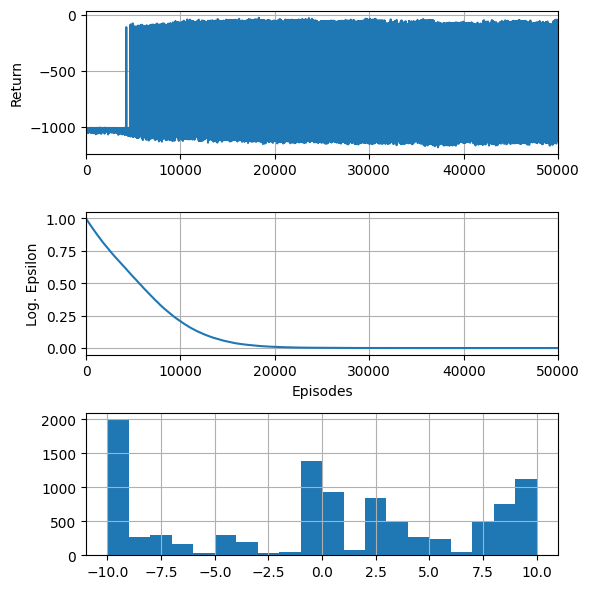

In [86]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes = axes.flatten()
axes[0].plot(Gs)
axes[0].set_xlim(0, E)
axes[0].grid()
axes[0].set_ylabel("Return")
axes[1].plot(Eps)
axes[1].set_xlim(0, E)
axes[1].grid()
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Log. Epsilon")
axes[2].hist(As[-10_000:], bins=20)
axes[2].grid()
plt.tight_layout()
plt.show()

In [87]:
q_hat_raw = Q[:]

# Training - TLR

In [124]:
mass = .1
env = CartPoleEnv(mass)
nS = 10
nA = 10
k = 10

In [125]:
discretizer = Discretizer(
    min_points_states=[-4.8, -0.5, -0.42, -0.9],
    max_points_states=[4.8, 0.5, 0.42, 0.9],
    bucket_states=[nS]*4,
    min_points_actions=[-10],
    max_points_actions=[10],
    bucket_actions=[nA],
)

In [126]:
s, _ = env.reset()
s_idx = discretizer.get_state_index(s)
s_idx

(5, 5, 5, 4)

In [127]:
E = 50_000
H = 100
lr = 0.001
eps = 1.0
eps_decay = 0.999995
eps_min = 0.0
gamma = 0.99

def select_action(Q, s_idx, epsilon):
    if np.random.rand() < epsilon:
        idx = np.random.choice(nA)
    else:
        idx = Q(s_idx).argmax().item()
    
    a = discretizer.get_action_from_index(idx)
    return a[0], idx

Gs = []
Eps = []
As = []
Q = PARAFAC(dims=[nS, nS, nS, nS, nA], k=k, scale=1.0)
opt = torch.optim.Adam(Q.parameters(), lr=lr)
for episode in range(E):
    G = 0
    s, _ = env.reset()
    s_idx = discretizer.get_state_index(s)
    for h in range(H):
        a, a_idx = select_action(Q, s_idx, eps)
        sp, r, d, _, _ = env.step(a)
        sp_idx = discretizer.get_state_index(sp)
        
        G += r
        
        m = -1*(d - 1)
        q_target = torch.tensor(r) + gamma * m * Q(sp_idx).max().detach()
        q_hat = Q(s_idx + tuple([a_idx]))
        
        opt.zero_grad()
        loss = torch.nn.MSELoss()
        loss(q_hat, q_target).backward()
        opt.step()
        
        if d:
            break
            
        s = sp
        s_idx = sp_idx
        eps = max(eps*eps_decay, eps_min)
        As.append(a)
    Gs.append(G)
    Eps.append(eps)

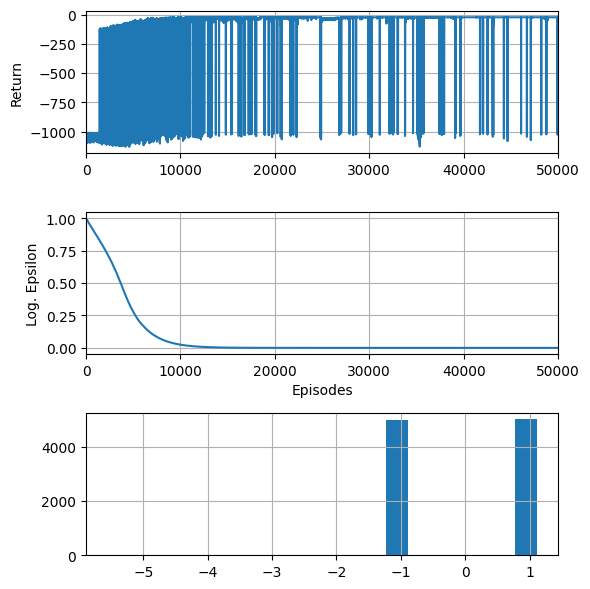

In [128]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes = axes.flatten()
axes[0].plot(Gs)
axes[0].set_xlim(0, E)
axes[0].grid()
axes[0].set_ylabel("Return")
axes[1].plot(Eps)
axes[1].set_xlim(0, E)
axes[1].grid()
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Log. Epsilon")
axes[2].hist(As[-10_000:], bins=20)
axes[2].grid()
plt.tight_layout()
plt.show()

In [129]:
factors = []
for factor in Q.parameters():
    factors.append(factor.detach().numpy())

In [130]:
q_hat_single = tl.cp_to_tensor((np.ones(k), factors))
q_hat_single.shape

(10, 10, 10, 10, 10)

# Multi-task Training

In [131]:
masses = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
envs = [CartPoleEnv(mass) for mass in masses]
nS = 10
nA = 20
nT = len(masses)
k = 10

In [132]:
discretizer = Discretizer(
    min_points_states=[-4.8, -0.5, -0.42, -0.9],
    max_points_states=[4.8, 0.5, 0.42, 0.9],
    bucket_states=[nS]*4,
    min_points_actions=[-10],
    max_points_actions=[10],
    bucket_actions=[nA],
)

In [133]:
E = 10_000
H = 100
lr = 0.001
eps = 1.0
eps_decay = 0.999995
eps_min = 0.0
gamma = 0.99

def select_action(Q, s_idx, epsilon):
    if np.random.rand() < epsilon:
        idx = np.random.choice(nA)
    else:
        idx = Q(s_idx).argmax().item()
    
    a = discretizer.get_action_from_index(idx)
    return a[0], idx

Gs = []
GTs = [list() for _ in range(nT)]
ATs = [list() for _ in range(nT)]
Eps = []
Q = PARAFAC(dims=[nT, nS, nS, nS, nS, nA], k=k, scale=1.0)
opt = torch.optim.Adam(Q.parameters(), lr=lr)
for episode in range(E):
    for env_idx, env in enumerate(envs):
        G = 0
        s, _ = env.reset()
        s_idx = tuple([env_idx]) + discretizer.get_state_index(s)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            sp, r, d, _, _ = env.step(a)
            sp_idx = tuple([env_idx]) + discretizer.get_state_index(sp)

            G += r

            m = -1*(d - 1)
            q_target = torch.tensor(r) + gamma * m * Q(sp_idx).max().detach()
            q_hat = Q(s_idx + tuple([a_idx]))

            opt.zero_grad()
            loss = torch.nn.MSELoss()
            loss(q_hat, q_target).backward()
            opt.step()

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)
            
            ATs[env_idx].append(a)
        Gs.append(G)
        GTs[env_idx].append(G)
        Eps.append(eps)

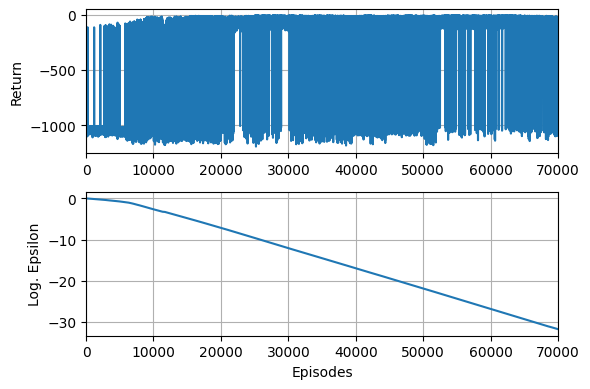

In [134]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4))
axes = axes.flatten()
axes[0].plot(Gs)
axes[0].set_xlim(0, E*nT)
axes[0].grid()
axes[0].set_ylabel("Return")
axes[1].plot(np.log(Eps))
axes[1].set_xlim(0, E*nT)
axes[1].grid()
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Log. Epsilon")
plt.tight_layout()
plt.show()

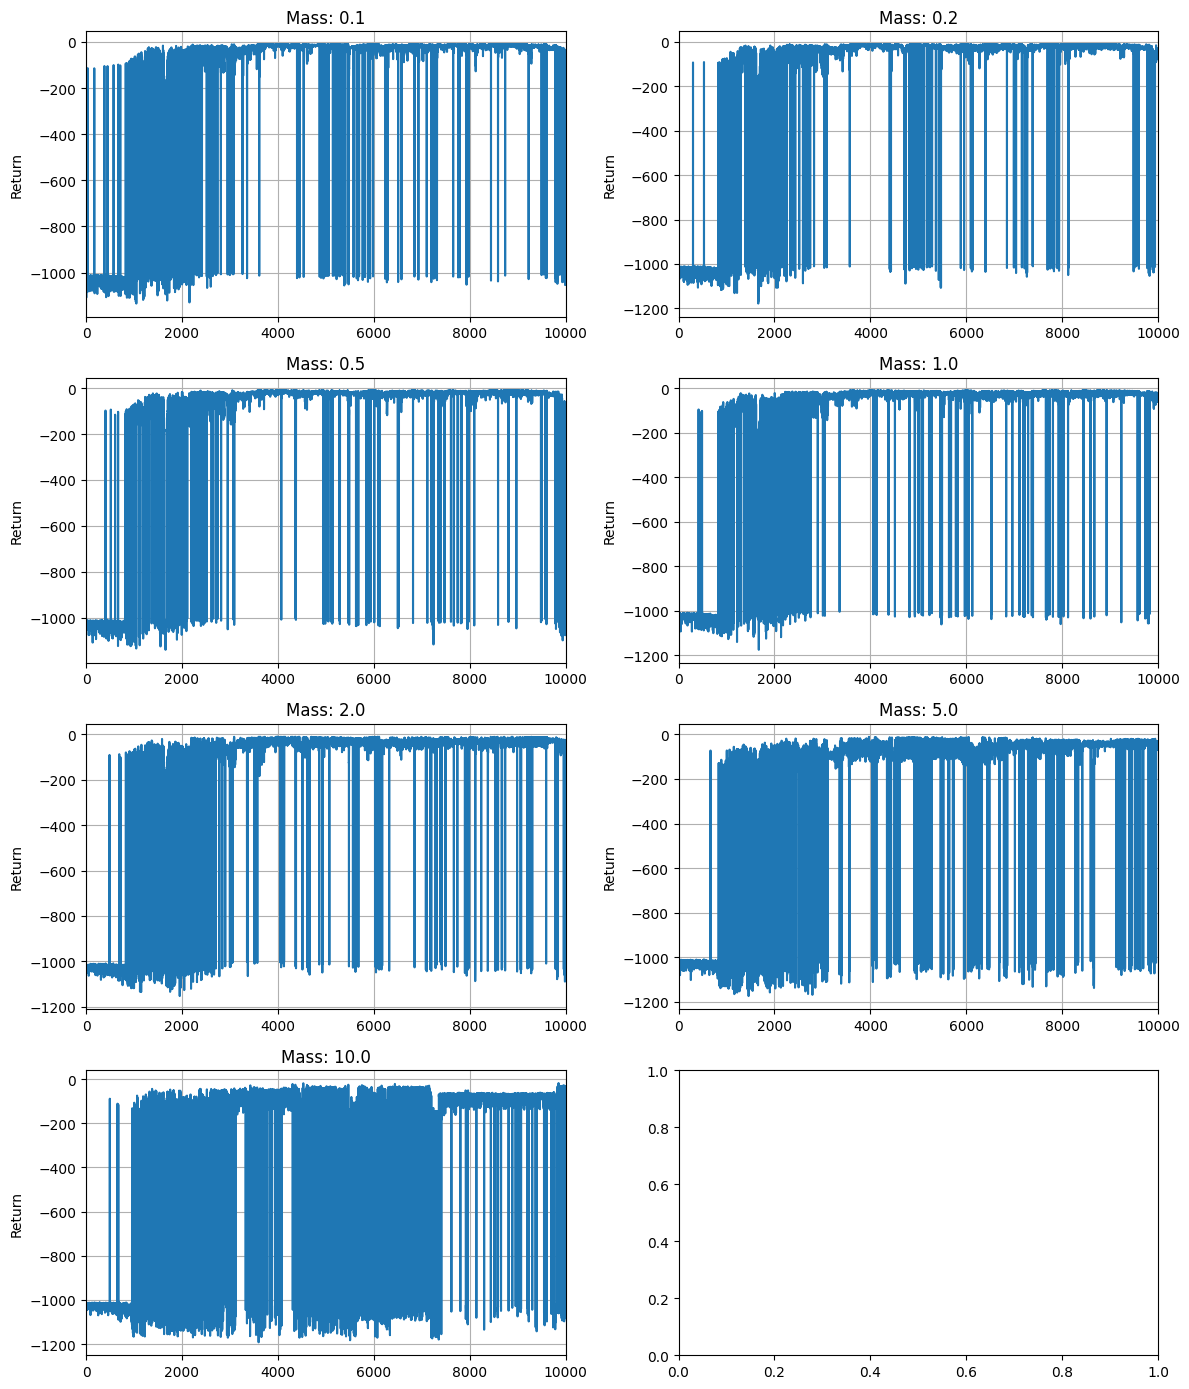

In [135]:
fig, axes = plt.subplots(4, 2, figsize=(12, 2*nT))
axes = axes.flatten()
for i in range(nT):
    axes[i].set_title(f"Mass: {masses[i]}")
    axes[i].plot(GTs[i])
    axes[i].set_xlim(0, E)
    axes[i].grid()
    axes[i].set_ylabel("Return")
plt.tight_layout()
plt.show()

In [136]:
factors = []
for factor in Q.parameters():
    factors.append(factor.detach().numpy())

In [137]:
q_hat_multi = tl.cp_to_tensor((np.ones(10), factors))
q_hat_multi.shape

(7, 10, 10, 10, 10, 20)

# Comparison between estimations

In [55]:
import copy 

q_hat_single_copy = copy.deepcopy(q_hat_single)
q_hat_multi_copy = copy.deepcopy(q_hat_multi)

In [56]:
mask = np.where(q_hat_raw == 0)
mask_inv = np.where(q_hat_raw != 0)
q_hat_single[mask] = 0.0
for i in range(nT):
    q_hat_multi[i][mask] = 0.0

In [57]:
np.linalg.norm(q_hat_raw)

1409.1220051978403

NFE: 53.31 %


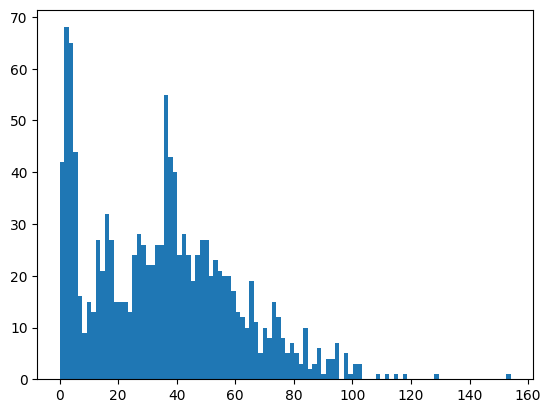

In [58]:
res = (q_hat_multi[0][mask_inv] - q_hat_single[mask_inv]).flatten()
norm = np.linalg.norm(q_hat_single)
print(f"NFE: {np.around(100 * np.linalg.norm(res) / np.linalg.norm(q_hat_single), 2)} %")

plt.hist(np.abs(res), bins=100)
plt.show()

In [66]:
q_static_cart = q_hat_raw[5, 5]
q_static_cart_single = q_hat_single[5, 5]
q_static_cart_multi = q_hat_multi[0][5, 5]
action = q_static_cart.argmax(2)
action_single = q_static_cart_single.argmax(2)
action_multi = q_static_cart_multi.argmax(2)

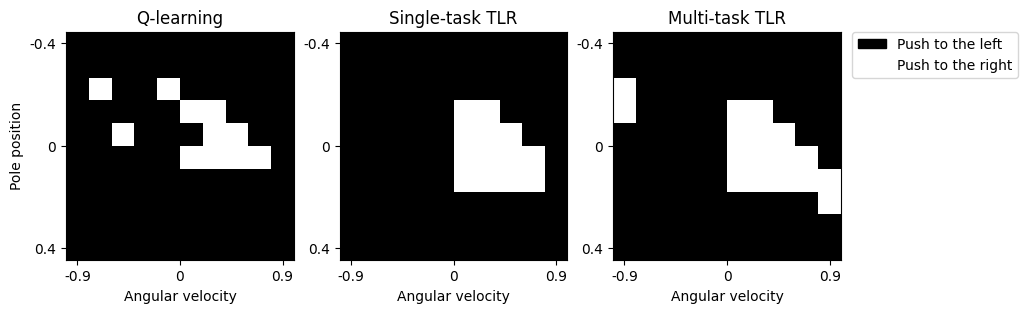

In [67]:
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.title("Q-learning")
img1 = plt.imshow(action, cmap='gray')
plt.xticks([0, 4.5, 9], [-0.9, 0, 0.9])
plt.yticks([0, 4.5, 9], [-0.4, 0, 0.4])
plt.xlabel("Angular velocity")
plt.ylabel("Pole position")

plt.subplot(132)
plt.title("Single-task TLR")
img2 = plt.imshow(action_single, cmap='gray')
plt.xticks([0, 4.5, 9], [-0.9, 0, 0.9])
plt.yticks([0, 4.5, 9], [-0.4, 0, 0.4])
plt.xlabel("Angular velocity")

plt.subplot(133)
plt.title("Multi-task TLR")
img3 = plt.imshow(action_multi, cmap='gray')
plt.xticks([0, 4.5, 9], [-0.9, 0, 0.9])
plt.yticks([0, 4.5, 9], [-0.4, 0, 0.4])
plt.xlabel("Angular velocity")

colors = [
    img1.cmap(img1.norm(0)),
    img1.cmap(img1.norm(1))
]

patches = [
    mpatches.Patch(color=colors[0], label="Push to the left"),
    mpatches.Patch(color=colors[1], label="Push to the right"),
]

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

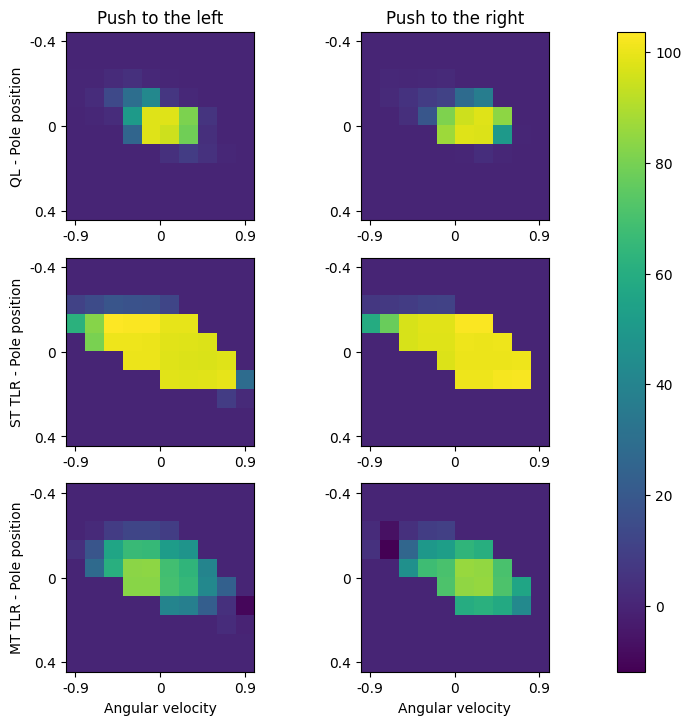

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# first, calculate the overall min and max values across all datasets
vmin = np.min([q_static_cart.min(), q_static_cart_single.min(), q_static_cart_multi.min()])
vmax = np.max([q_static_cart.max(), q_static_cart_single.max(), q_static_cart_multi.max()])

plt.figure(figsize=(8, 8))

# Q-learning mass 0.1
plt.subplot(321)
plt.title("Push to the left")
plt.imshow(q_static_cart[:, :, 0], vmin=vmin, vmax=vmax)
plt.xticks([0, 4.5, 9], [-0.9, 0, 0.9])
plt.yticks([0, 4.5, 9], [-0.4, 0, 0.4])
plt.ylabel("QL - Pole position")

plt.subplot(322)
plt.title("Push to the right")
plt.imshow(q_static_cart[:, :, 1], vmin=vmin, vmax=vmax)
plt.xticks([0, 4.5, 9], [-0.9, 0, 0.9])
plt.yticks([0, 4.5, 9], [-0.4, 0, 0.4])

# TLR single task mass 0.1
plt.subplot(323)
plt.imshow(q_static_cart_single[:, :, 0], vmin=vmin, vmax=vmax)
plt.xticks([0, 4.5, 9], [-0.9, 0, 0.9])
plt.yticks([0, 4.5, 9], [-0.4, 0, 0.4])
plt.ylabel("ST TLR - Pole position")

plt.subplot(324)
plt.imshow(q_static_cart_single[:, :, 1], vmin=vmin, vmax=vmax)
plt.xticks([0, 4.5, 9], [-0.9, 0, 0.9])
plt.yticks([0, 4.5, 9], [-0.4, 0, 0.4])

# TLR multi task mass 0.1
plt.subplot(325)
plt.imshow(q_static_cart_multi[:, :, 0], vmin=vmin, vmax=vmax)
plt.xticks([0, 4.5, 9], [-0.9, 0, 0.9])
plt.yticks([0, 4.5, 9], [-0.4, 0, 0.4])
plt.xlabel("Angular velocity")
plt.ylabel("MT TLR - Pole position")

plt.subplot(326)
plt.imshow(q_static_cart_multi[:, :, 1], vmin=vmin, vmax=vmax)
plt.xticks([0, 4.5, 9], [-0.9, 0, 0.9])
plt.yticks([0, 4.5, 9], [-0.4, 0, 0.4])
plt.xlabel("Angular velocity")

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.035, 0.8])
plt.colorbar(cax=cax)

plt.show()

In [69]:
q_static_cart = q_hat_raw[:, :, 5, 5, :]
q_static_cart_single = q_hat_single[:, :, 5, 5, :]
q_static_cart_multi = q_hat_multi[0][:, :, 5, 5, :]
action = q_static_cart.argmax(2)
action_single = q_static_cart_single.argmax(2)
action_multi = q_static_cart_multi.argmax(2)

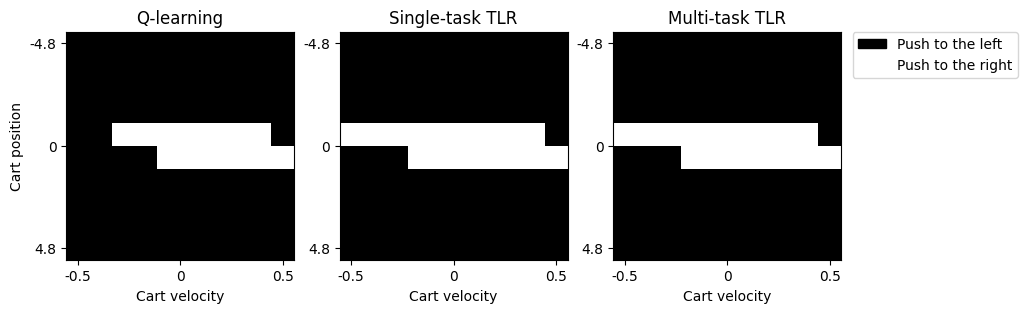

In [70]:
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.title("Q-learning")
img1 = plt.imshow(action, cmap='gray')
plt.xticks([0, 4.5, 9], [-0.5, 0, 0.5])
plt.yticks([0, 4.5, 9], [-4.8, 0, 4.8])
plt.xlabel("Cart velocity")
plt.ylabel("Cart position")

plt.subplot(132)
plt.title("Single-task TLR")
img2 = plt.imshow(action_single, cmap='gray')
plt.xticks([0, 4.5, 9], [-0.5, 0, 0.5])
plt.yticks([0, 4.5, 9], [-4.8, 0, 4.8])
plt.xlabel("Cart velocity")

plt.subplot(133)
plt.title("Multi-task TLR")
img3 = plt.imshow(action_multi, cmap='gray')
plt.xticks([0, 4.5, 9], [-0.5, 0, 0.5])
plt.yticks([0, 4.5, 9], [-4.8, 0, 4.8])
plt.xlabel("Cart velocity")

colors = [
    img1.cmap(img1.norm(0)),
    img1.cmap(img1.norm(1))
]

patches = [
    mpatches.Patch(color=colors[0], label="Push to the left"),
    mpatches.Patch(color=colors[1], label="Push to the right"),
]

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

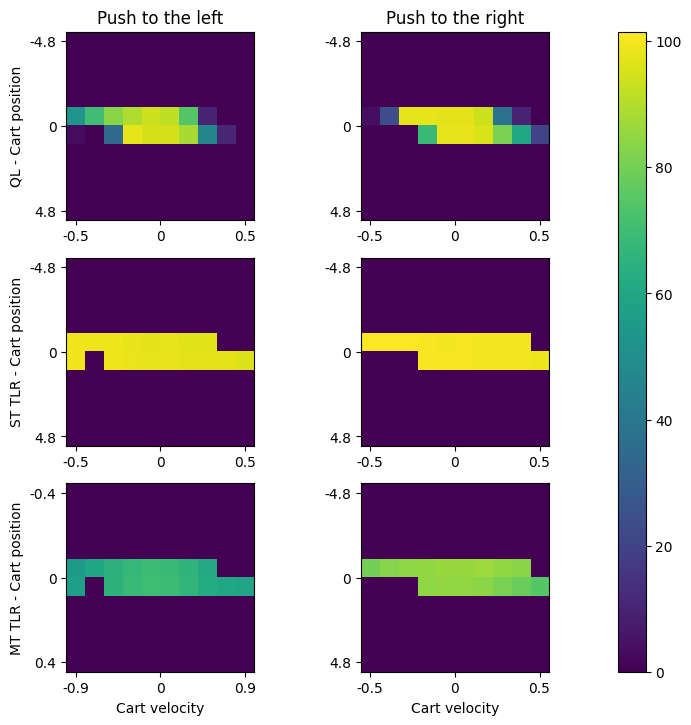

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# first, calculate the overall min and max values across all datasets
vmin = np.min([q_static_cart.min(), q_static_cart_single.min(), q_static_cart_multi.min()])
vmax = np.max([q_static_cart.max(), q_static_cart_single.max(), q_static_cart_multi.max()])

plt.figure(figsize=(8, 8))

# Q-learning mass 0.1
plt.subplot(321)
plt.title("Push to the left")
plt.imshow(q_static_cart[:, :, 0], vmin=vmin, vmax=vmax)
plt.xticks([0, 4.5, 9], [-0.5, 0, 0.5])
plt.yticks([0, 4.5, 9], [-4.8, 0, 4.8])
plt.ylabel("QL - Cart position")

plt.subplot(322)
plt.title("Push to the right")
plt.imshow(q_static_cart[:, :, 1], vmin=vmin, vmax=vmax)
plt.xticks([0, 4.5, 9], [-0.5, 0, 0.5])
plt.yticks([0, 4.5, 9], [-4.8, 0, 4.8])

# TLR single task mass 0.1
plt.subplot(323)
plt.imshow(q_static_cart_single[:, :, 0], vmin=vmin, vmax=vmax)
plt.xticks([0, 4.5, 9], [-0.5, 0, 0.5])
plt.yticks([0, 4.5, 9], [-4.8, 0, 4.8])
plt.ylabel("ST TLR - Cart position")

plt.subplot(324)
plt.imshow(q_static_cart_single[:, :, 1], vmin=vmin, vmax=vmax)
plt.xticks([0, 4.5, 9], [-0.5, 0, 0.5])
plt.yticks([0, 4.5, 9], [-4.8, 0, 4.8])

# TLR multi task mass 0.1
plt.subplot(325)
plt.imshow(q_static_cart_multi[:, :, 0], vmin=vmin, vmax=vmax)
plt.xticks([0, 4.5, 9], [-0.9, 0, 0.9])
plt.yticks([0, 4.5, 9], [-0.4, 0, 0.4])
plt.xlabel("Cart velocity")
plt.ylabel("MT TLR - Cart position")

plt.subplot(326)
plt.imshow(q_static_cart_multi[:, :, 1], vmin=vmin, vmax=vmax)
plt.xticks([0, 4.5, 9], [-0.5, 0, 0.5])
plt.yticks([0, 4.5, 9], [-4.8, 0, 4.8])
plt.xlabel("Cart velocity")

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.035, 0.8])
plt.colorbar(cax=cax)

plt.show()

# Multi-task Training Single Agent

In [72]:
masses = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
#masses = [0.1, 5.0, 10.0, 20, 30]
envs = [CartPoleEnv(mass) for mass in masses]
nS = 10
nA = 20
nT = len(masses)
k = 10

In [73]:
discretizer = Discretizer(
    min_points_states=[-4.8, -0.5, -0.42, -0.9],
    max_points_states=[4.8, 0.5, 0.42, 0.9],
    bucket_states=[nS]*4,
    min_points_actions=[-10],
    max_points_actions=[10],
    bucket_actions=[nA],
)

In [74]:
E = 20_000
H = 100
lr = 0.001
eps = 1.0
eps_decay = 0.99999
eps_min = 0.0
gamma = 0.99

def select_action(Q, s_idx, epsilon):
    if np.random.rand() < epsilon:
        idx = np.random.choice(nA)
    else:
        idx = Q(s_idx).argmax().item()
    
    a = discretizer.get_action_from_index(idx)
    return a[0], idx

Gs = []
GTs = [list() for _ in range(nT)]
ATs = [list() for _ in range(nT)]
Eps = []
Q = PARAFAC(dims=[nS, nS, nS, nS, nA], k=k, scale=1.0)
opt = torch.optim.Adam(Q.parameters(), lr=lr)
for episode in range(E):
    for env_idx, env in enumerate(envs):
        G = 0
        s, _ = env.reset()
        s_idx = discretizer.get_state_index(s)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            sp, r, d, _, _ = env.step(a)
            sp_idx = discretizer.get_state_index(sp)

            G += r

            m = -1*(d - 1)
            q_target = torch.tensor(r) + gamma * m * Q(sp_idx).max().detach()
            q_hat = Q(s_idx + tuple([a_idx]))

            opt.zero_grad()
            loss = torch.nn.MSELoss()
            loss(q_hat, q_target).backward()
            opt.step()

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)
            
            ATs[env_idx].append(a)
        Gs.append(G)
        GTs[env_idx].append(G)
        Eps.append(eps)

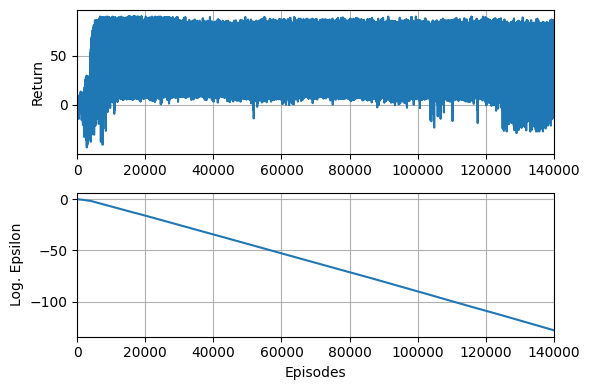

In [75]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4))
axes = axes.flatten()
axes[0].plot(Gs)
axes[0].set_xlim(0, E*nT)
axes[0].grid()
axes[0].set_ylabel("Return")
axes[1].plot(np.log(Eps))
axes[1].set_xlim(0, E*nT)
axes[1].grid()
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Log. Epsilon")
plt.tight_layout()
plt.show()

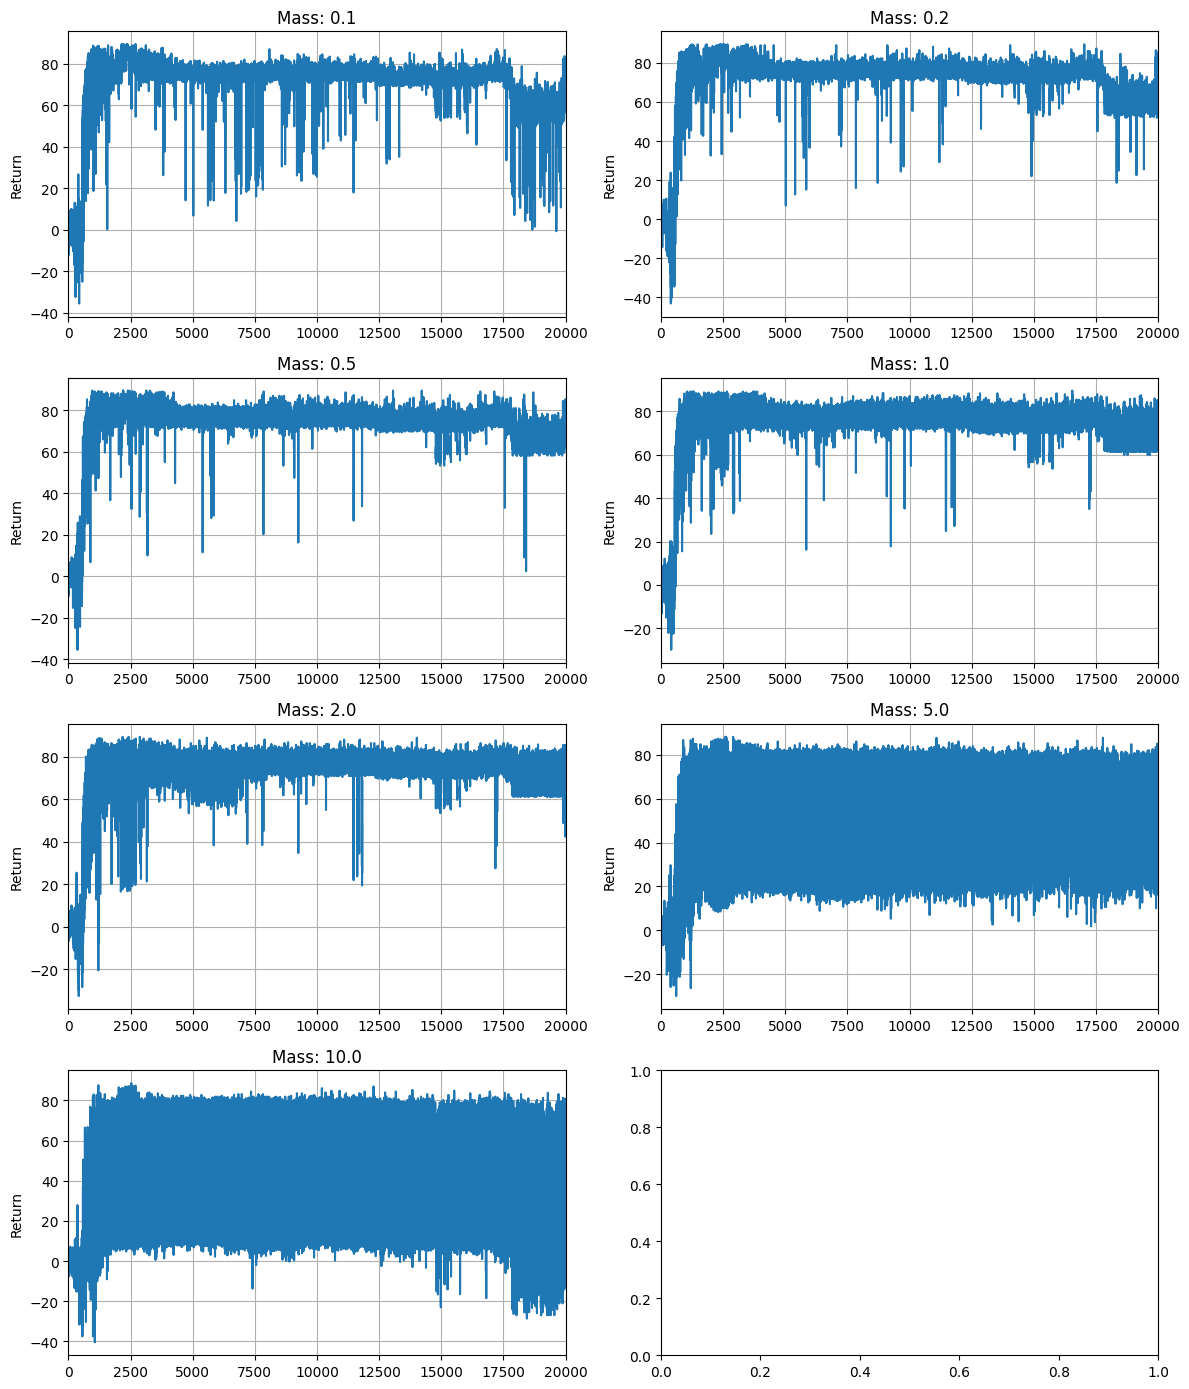

In [76]:
fig, axes = plt.subplots(4, 2, figsize=(12, 2*nT))
axes = axes.flatten()
for i in range(nT):
    axes[i].set_title(f"Mass: {masses[i]}")
    axes[i].plot(GTs[i])
    axes[i].set_xlim(0, E)
    axes[i].grid()
    axes[i].set_ylabel("Return")
plt.tight_layout()
plt.show()

TODOs:
- Discrete actions + cost 
- Aumentar rango tensor
- Navegación en múltiples entornos (goals en una grid)